# Path selector

This is the first proposal to go beyond the basic support for analysis provided

The idea is to explore alternative path combinations from a crystal file and determine which paths are the best fit (determined from the R-factor. 

The starting point is reproducing figure 6.

>Fig. 6 Mn K-edge EXAFS data after 4 h of milling in (A) atmospheric and (B) inert milling conditions showing the magnitude and imaginary components of the k2-weighted FT data and fits compared to (C) sol–gel synthesised LaMnO3. 

The operations performed are:

1. Read data and metadata
2. Generate scattering paths
3. Test path combinations
4. 


In [1]:
# code for importing custom helper libraries
import sys
# moved all custom helper libraries to a level bellow this directory.
sys.path.append('../lib/')

# Library with the functions that replicate athena:
# normalisation, merging, re-binning, 
# and visualisation (plotting)
import manage_athena as athenamgr  

# Library with the functions that execute 
# Atoms and FEFF to generate scattering paths
import atoms_feff as feff_runner     

# Set parameters          
# library containign functions tho manage fit, at read, write 
# GDS parameters, and scattering paths. 
import manage_fit as fit_manager  

from larch import Interpreter

# read data from csv files
import handle_csv as csvhandler

# update imported files while running 
import importlib

# File handling
from pathlib import Path

# custom plotting functions
import custom_plots 

# parse json data
import json

# formated printing of json data
import pprint

# python plotting library
import matplotlib.pyplot as plt
# inline: shows plot in notebook
# tk: shows plot in popup
%matplotlib inline 


session = Interpreter()

No conda env active, defaulting to base


# 1 Read data from athena project

## 1.1 Read metadata

In [2]:
json_file = "./mappings_metadata.json"
json_metadata = {}

with open(json_file) as json_data:
    json_metadata = json.load(json_data)

pprint.pprint(json_metadata)

json_file = "operations_metadata.json"
operations_data = {}
print("*"*80)
with open(json_file) as json_data:
    operations_data = json.load(json_data)
    
pprint.pprint(operations_data)

{'data_file': 'Xray_data.zip',
 'data_mapping': [{'data_path': '../wf_data/pub_723/DS0747',
                   'data_type': 'athena',
                   'file_mappings': [{'file_name': 'Figure_6_7A_B_XAFS.prj',
                                      'group': 'Sol-Gel',
                                      'group_name': 'Mn_Sol_gel'},
                                     {'file_name': 'Figure_6_7A_B_XAFS.prj',
                                      'group': 'Air Milled',
                                      'group_name': 'Mn_air_milled'},
                                     {'file_name': 'Figure_6_7A_B_XAFS.prj',
                                      'group': 'Argon Milled',
                                      'group_name': 'Mn_argon_milled'}]}],
 'data_object': {'cdi_do': 747, 'doi': '10.5258/SOTON/D1342'},
 'figure_id': 'Figure 6',
 'figure_legend': 'Fig. 6 Mn K-edge EXAFS data after 4 h of milling in (A) '
                  'atmospheric and (B) inert milling conditions showing the

# 1.2 Read data

Use metadata to read the data

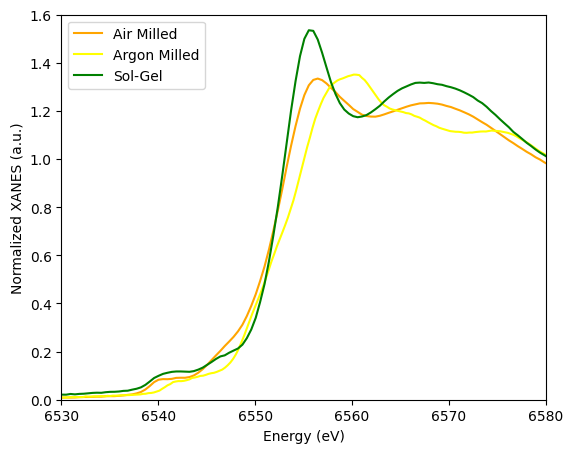

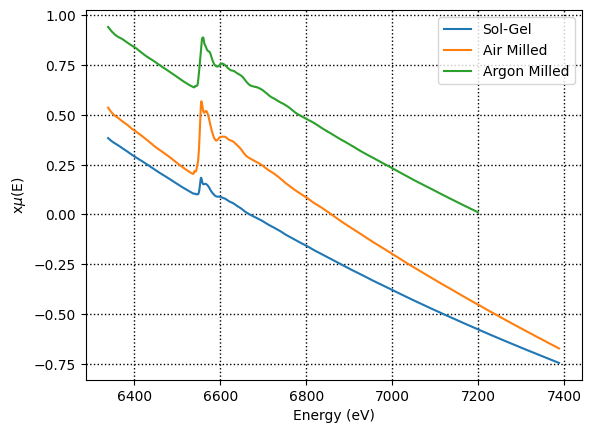

In [3]:
f6_groups={}

for a_set in json_metadata["data_mapping"]:
    project_path = Path(a_set["data_path"])
    for a_mapping in a_set["file_mappings"]:    # project file name
        project_name = a_mapping['file_name']
        # name assigned to the readings for processing and display
        data_group =  a_mapping['group']    
        # the group names use underscores instead of spaces and periods 
        # in athena file
        group_name =  a_mapping['group_name']
        # read each group from the corresponding project file
        athena_project = athenamgr.read_project(Path(project_path,project_name))

        f6_groups[data_group] = athenamgr.get_group(athena_project, group_name)
        f6_groups[data_group].filename = data_group
#define dict to set colours and line stiles

f6_plot_groups={"Air Milled": ["orange", "solid"],
                "Argon Milled": ["yellow", "solid"],
                "Sol-Gel": ["green", "solid"],}

plt = custom_plots.plot_normalised(f6_groups, f6_plot_groups,(6.25,5),[6530, 6580],[0,1.6])
plt.show()

for a_group in f6_groups:
   plt = athenamgr.plot_mu(f6_groups[a_group])

plt.title("")

plt.show()

# 2 Generate scattering paths
This has two subtasks, first reading the metadata and then running feff to get the paths.

## 2.1 Read the fitting variables 
Fitting variables include all resources used for fitting, this includes the crystal files used.

In [4]:
# get run_feff variables from metadata
# get parameters for EXAFS first
exafs_variables = operations_data['task_list'][0]

# we know we are reading data for EXAFS and
# that variables hold the required values
data_path = Path(exafs_variables["variables"]["data_path"])
crystal_files = []
for a_file in exafs_variables["variables"]["crystal_files"]:
    crystal_files.append(str(Path(data_path, a_file)))
    
print(crystal_files)

##########################
# variables for fit

fit_vars = exafs_variables["variables"]["fit_vars"]

##########################
# Absorbing atom(s) and maximum radius

absorbing_atoms = exafs_variables["variables"]["absorbing_atoms"]
max_radius = exafs_variables["variables"]["max_radius"]

['..\\wf_data\\pub_723\\additional\\1667441.cif']


## 2.2 Generate scattering paths
The run_feff function can run on a list of crystals and a list of corresponding absorbing atoms.
The result is returned as a list of directories where the scattering paths have been stored.


In [5]:
# run feff and get a list of feff dirs
feff_dirs = feff_runner.run_feff(crystal_files, absorbing_atoms, max_radius) 

# could prevent running if the files already exist and they are recent (<month old)

Processing: ..\wf_data\pub_723\additional\1667441.cif
check if need to build: 1667441_feff
 : ======== running Feff module C:\Users\scman1\AppData\Local\Programs\Python\Python39\lib\site-packages\larch\bin\win64\feff6l.exe ========
 : Feff 6L.02
 : Formula:    LaMnO3
 : SpaceGroup: Pm-3m
 : # sites:    5
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : free atom potential and density for atom type    3
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : overlapped potential and density for unique potential    3
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique potential    2
 : phase shifts 

In [6]:
for a_file in crystal_files:
    crystal_f = Path(a_file)
    feff_dir = "./"+crystal_f.name[:-4]+"_feff"
    
    paths_info = fit_manager.get_path_labels(Path(feff_dir, 'paths.dat'))
    
    print (paths_info)
    fit_manager.get_path_labels(Path(feff_dir, 'paths.dat'))

path_sheet = fit_manager.show_feff_paths(crystal_files)
display(path_sheet)

paths_data = fit_manager.get_path_details(crystal_files)
print (paths_data)

{'1': {'index': '1', 'nleg': '2', 'degeneracy': '6.000', 'label': 'O.Mn'}, '2': {'index': '2', 'nleg': '3', 'degeneracy': '24.000', 'label': 'O.O.Mn'}, '3': {'index': '3', 'nleg': '2', 'degeneracy': '8.000', 'label': 'La.Mn'}, '4': {'index': '4', 'nleg': '2', 'degeneracy': '4.000', 'label': 'Mn.Mn'}, '5': {'index': '5', 'nleg': '2', 'degeneracy': '2.000', 'label': 'Mn.Mn'}, '6': {'index': '6', 'nleg': '3', 'degeneracy': '6.000', 'label': 'O.O.Mn'}, '7': {'index': '7', 'nleg': '3', 'degeneracy': '8.000', 'label': 'Mn.O.Mn'}, '8': {'index': '8', 'nleg': '3', 'degeneracy': '4.000', 'label': 'Mn.O.Mn'}, '9': {'index': '9', 'nleg': '4', 'degeneracy': '6.000', 'label': 'O.Mn.O.Mn'}, '10': {'index': '10', 'nleg': '4', 'degeneracy': '6.000', 'label': 'O.Mn.O.Mn'}, '11': {'index': '11', 'nleg': '4', 'degeneracy': '4.000', 'label': 'O.Mn.O.Mn'}, '12': {'index': '12', 'nleg': '4', 'degeneracy': '2.000', 'label': 'O.Mn.O.Mn'}, '13': {'index': '13', 'nleg': '4', 'degeneracy': '24.000', 'label': 'O.

Sheet(cells=(Cell(column_end=7, column_start=0, row_end=12, row_start=0, squeeze_column=False, squeeze_row=Fal…

[['file', 'sig2', 'amp_rati', 'deg', 'nlegs', 'r_effective', 'label', 'select'], ['1667441_feff/feff0001.dat', '0.00000', '100.000', '6.000', '2', '1.9398', 'O.Mn.1', 0], ['1667441_feff/feff0002.dat', '0.00000', '18.050', '24.000', '3', '3.3113', 'O.O.Mn.2', 0], ['1667441_feff/feff0003.dat', '0.00000', '58.072', '8.000', '2', '3.3596', 'La.Mn.3', 0], ['1667441_feff/feff0004.dat', '0.00000', '13.482', '4.000', '2', '3.8795', 'Mn.Mn.4', 0], ['1667441_feff/feff0005.dat', '0.00000', '6.737', '2.000', '2', '3.8805', 'Mn.Mn.5', 0], ['1667441_feff/feff0006.dat', '0.00000', '16.691', '6.000', '3', '3.8795', 'O.O.Mn.6', 0], ['1667441_feff/feff0007.dat', '0.00000', '37.767', '8.000', '3', '3.8795', 'Mn.O.Mn.7', 0], ['1667441_feff/feff0008.dat', '0.00000', '18.868', '4.000', '3', '3.8805', 'Mn.O.Mn.8', 0], ['1667441_feff/feff0009.dat', '0.00000', '16.800', '6.000', '4', '3.8805', 'O.Mn.O.Mn.9', 0], ['1667441_feff/feff0010.dat', '0.00000', '5.806', '6.000', '4', '3.8795', 'O.Mn.O.Mn.10', 0], ['166

# 3. Build path combinations

Create a list of path combinations following the filtering criteria (we started with first n paths in list).

In [7]:
# get parameters for saving results
pc_variables = operations_data['task_list'][2]['variables']

max_paths = pc_variables['max_paths'] # the maximum number of paths to use
min_cw_ratio = pc_variables['min_cw_ratio'] # FEFF ranking of the path (CW Ratio in Larch)
max_deg = pc_variables['max_deg'] # Degeneracy (number of identical scattering paths)
max_reff = pc_variables['max_reff'] # bond length for single scattering path (half path)

# list all the groups to be fitted
fit_groups={"Air Milled": ["orange", "solid"],
            "Argon Milled": ["yellow", "solid"],
            "Sol-Gel": ["green", "solid"],}


for a_file in crystal_files:
    crystal_f = Path(a_file)
    feff_dir = "./"+crystal_f.name[:-4]+"_feff"
    paths_info = fit_manager.get_path_labels(Path(feff_dir, 'paths.dat'))
    list_combinations = []
    # combinations of the first five paths in the list (31 combinations):
    for indx in range(1,32):
        path_combination = list(format(indx,'05b')[::-1])
        # amp assigned does not change 
        # enot assigned does not change either
        gds_test = {1: {'id': '1', 'name': 'amp', 'value': '1.0', 'expr': '', 'vary': 'True'},
                    2: {'id': '2', 'name': 'enot', 'value': '0.0', 'expr': '', 'vary': 'True'},}
        sp_list = []
        path_count = 1
        ###
        # PENDING:
        # 1. Need to implement filters for cw_ratio,degeneracy and reff 
        #    and pass them as parameters in operation the metadata 
        # 2. Need to create a routine to mix and match paths from different crystals
        # 3. Need to move the generated paths to outputs dir
        ###
        for path_num, use in enumerate(path_combination):
            #if use == '1': # filter by number of files to include only
            #if use == '1' and int(paths_info[str(path_num+1)]['nleg'])<3: #filter by number of legs
            if use == '1' and float(paths_info[str(path_num+1)]['degeneracy'])<10.0: #filter by num. of identical paths
                # paths_info[str(path_num+1)]
                #print ("testing paths: ", path_num+1)
                #print ("add:", "ss_"+str(path_num+1) )
                #print ("add:", "delr_"+str(path_num+1) )
                id_num = len(gds_test)+1
                gds_test[id_num]={"id":id_num, 'name': "ss_"+str(path_num+1), 
                                 "value": '0.0', 'expr': '', 'vary': 'True'}
                id_num+=1
                gds_test[id_num]={"id":id_num, 'name': "delr_"+str(path_num+1), 
                                 "value": '0.0', 'expr': '', 'vary': 'True'}
                sp_list.append( {'id': path_count,
                                 'filename':feff_dir+"/feff"+"%04d"%(path_num+1)+".dat",
                                 'label':paths_info[str(path_num+1)]['label']+str(path_num+1),
                                 's02':"amp",
                                 'e0':"enot",
                                 'sigma2':"ss_"+str(path_num+1),
                                 'deltar':"delr_"+str(path_num+1)})
                path_count+=1
        list_combinations.append({"combination": path_combination,
                                  "c_pattern": ''.join(path_combination),
                                  "gds_vars":gds_test,"sp_vars":sp_list})

print("Path combinations:", len(list_combinations))

Path combinations: 31


# 4. test path combinations

Run a series of FEFF fits using each of the combinations in the valid combinations list. Build a list of the best combinitations 

Testing paths: ['1', '0', '0', '0', '0']
R-factor 28.66%


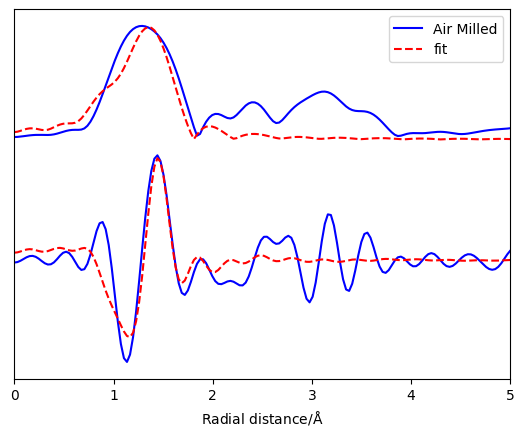

R-factor 58.85%


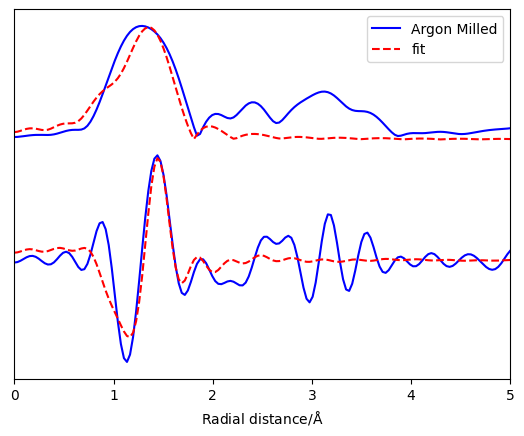

R-factor 38.69%


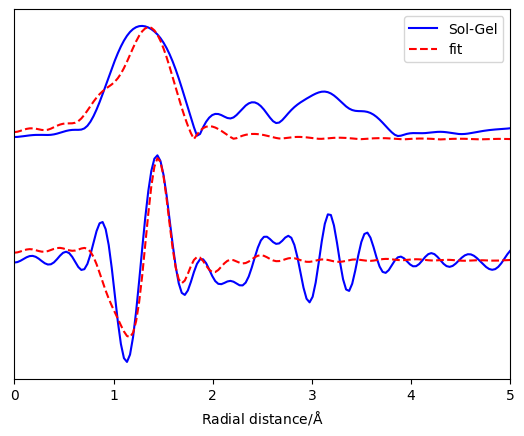

Testing paths: ['0', '1', '0', '0', '0']
R-factor 100.00%


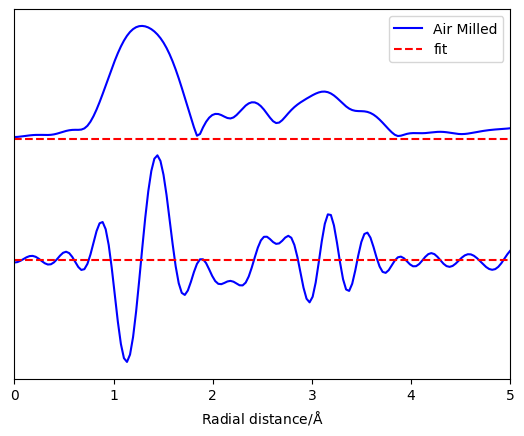

R-factor 100.00%


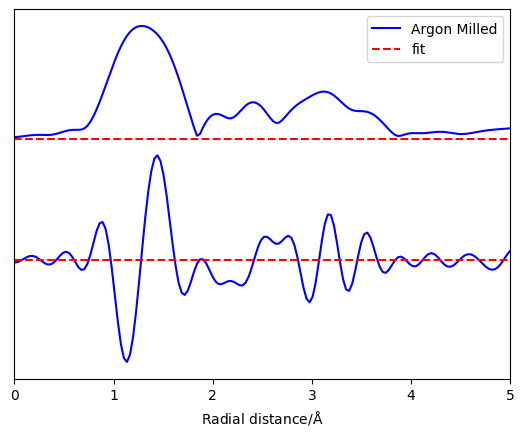

R-factor 100.00%


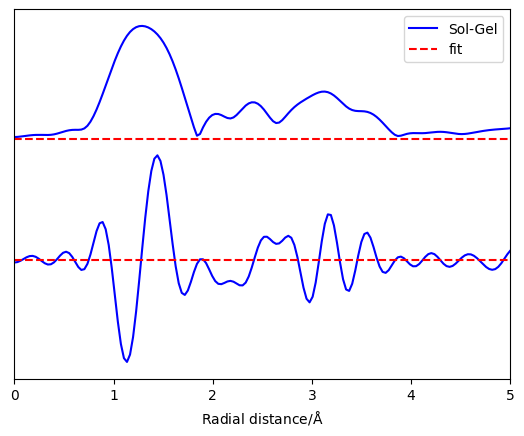

Testing paths: ['1', '1', '0', '0', '0']
R-factor 28.66%


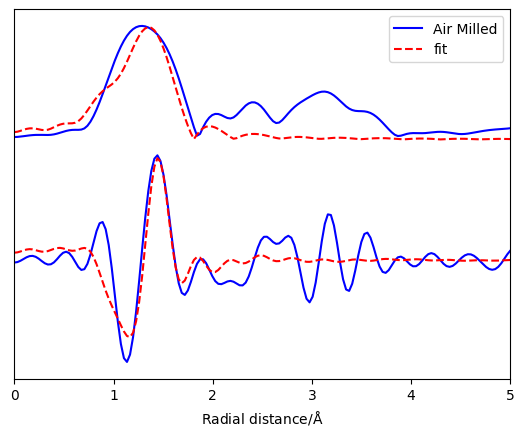

R-factor 58.85%


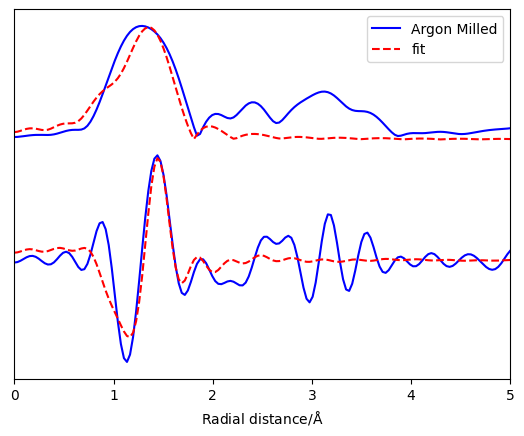

R-factor 38.69%


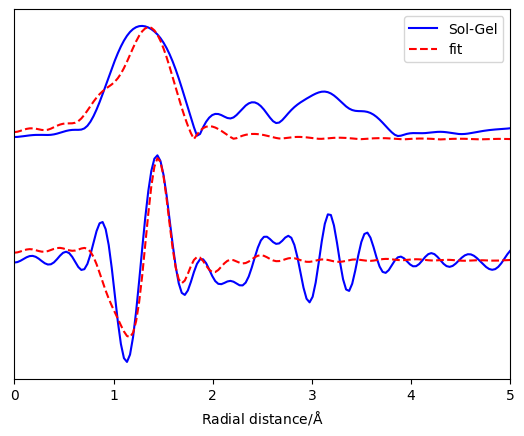

Testing paths: ['0', '0', '1', '0', '0']
R-factor 95.46%


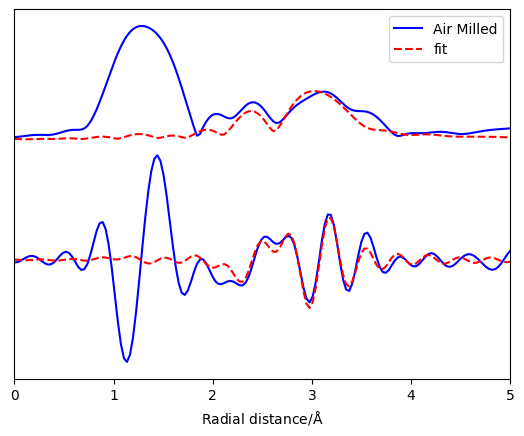

R-factor 64.49%


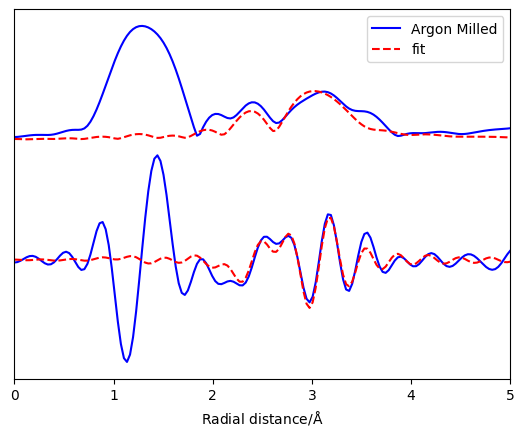

R-factor 84.34%


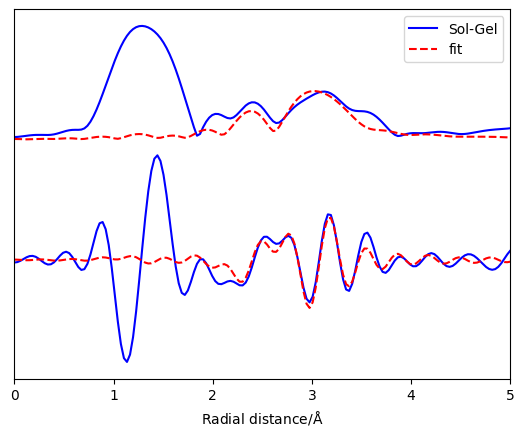

Testing paths: ['1', '0', '1', '0', '0']
R-factor 24.98%


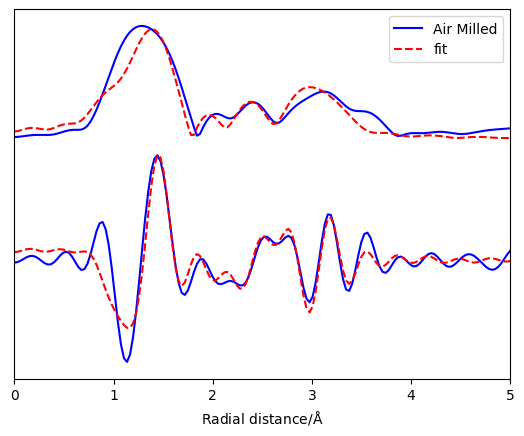

R-factor 27.02%


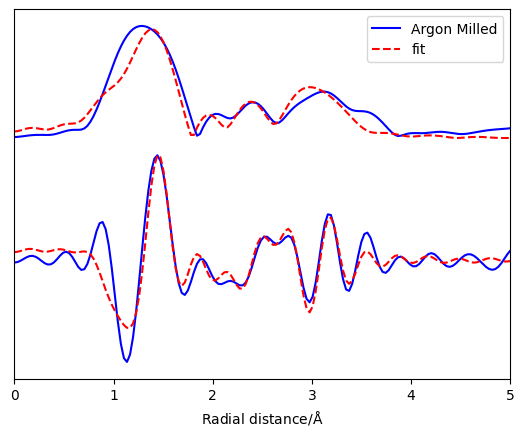

R-factor 22.27%


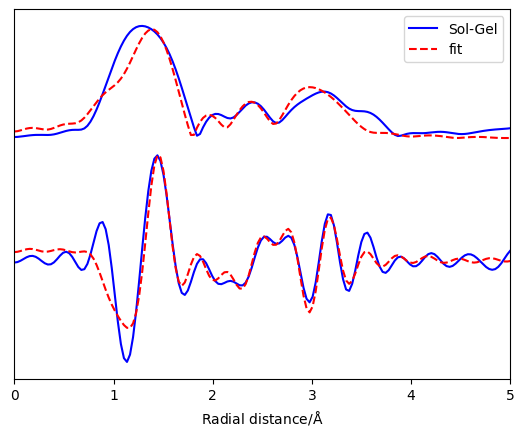

Testing paths: ['0', '1', '1', '0', '0']
R-factor 95.46%


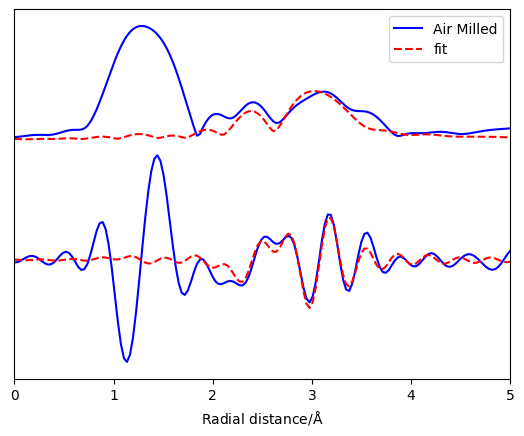

R-factor 64.49%


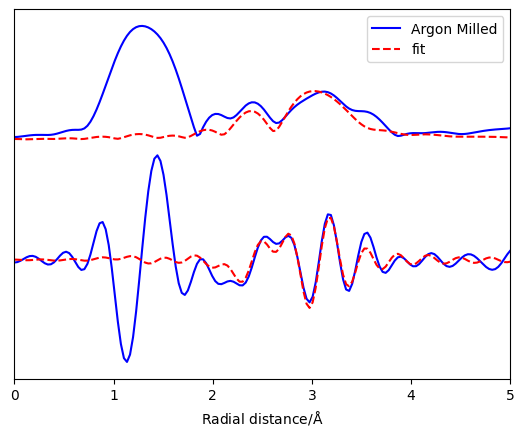

R-factor 84.34%


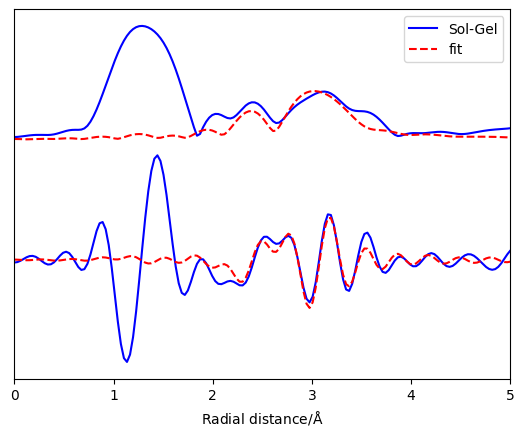

Testing paths: ['1', '1', '1', '0', '0']
R-factor 24.98%


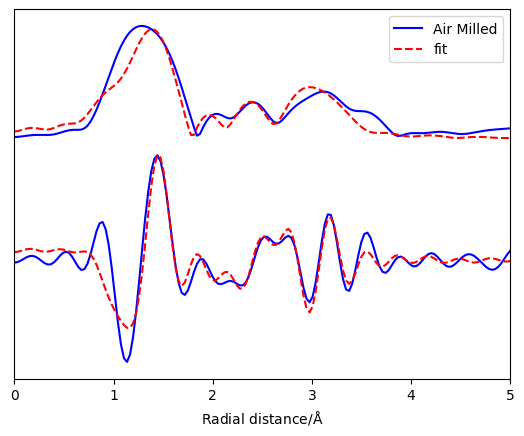

R-factor 27.02%


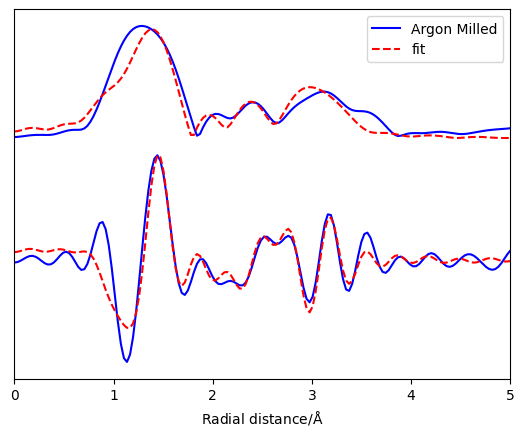

R-factor 22.27%


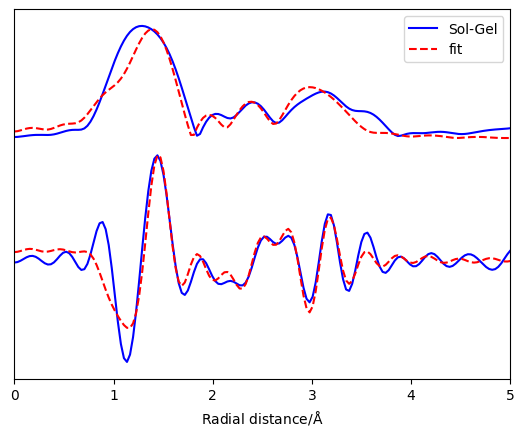

Testing paths: ['0', '0', '0', '1', '0']
R-factor 94.83%


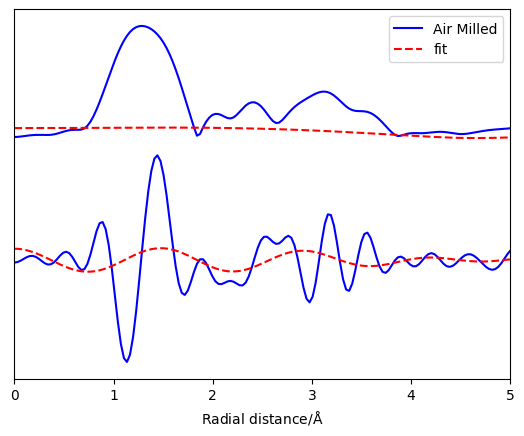

R-factor 60.46%


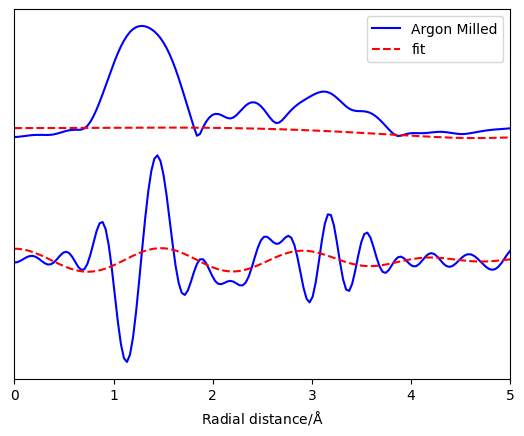

R-factor 95.32%


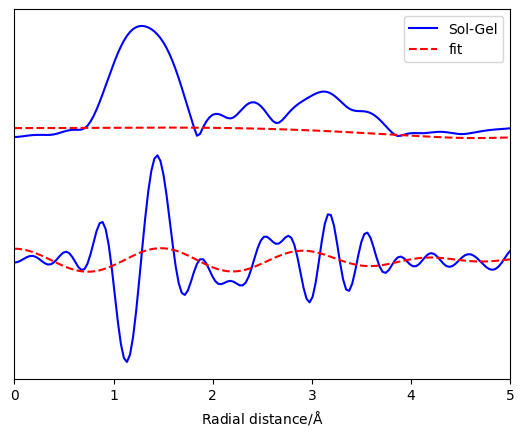

Testing paths: ['1', '0', '0', '1', '0']
R-factor 22.89%


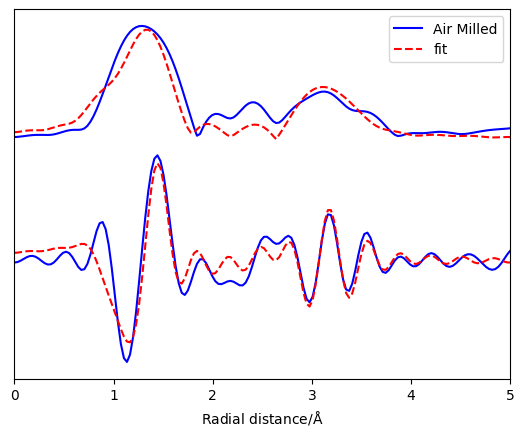

R-factor 58.85%


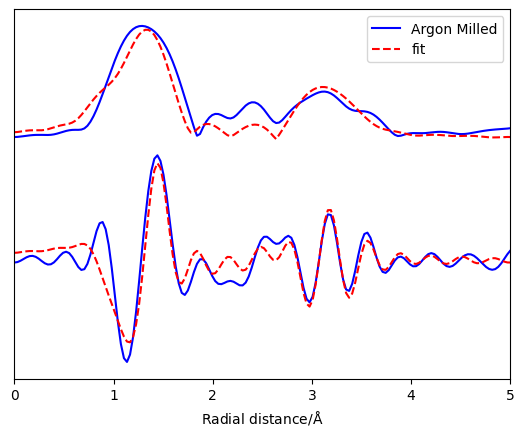

R-factor 23.76%


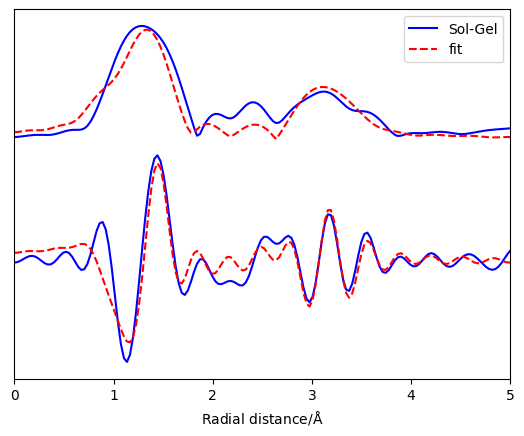

Testing paths: ['0', '1', '0', '1', '0']
R-factor 94.83%


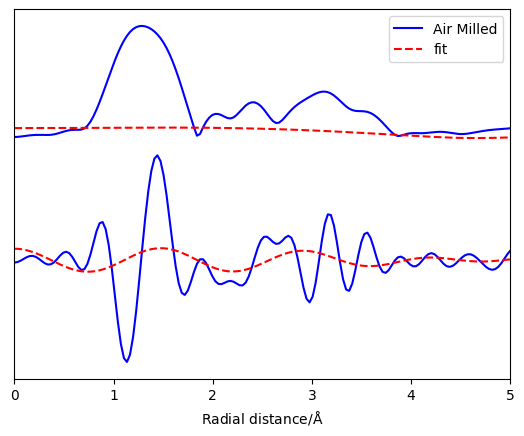

R-factor 60.46%


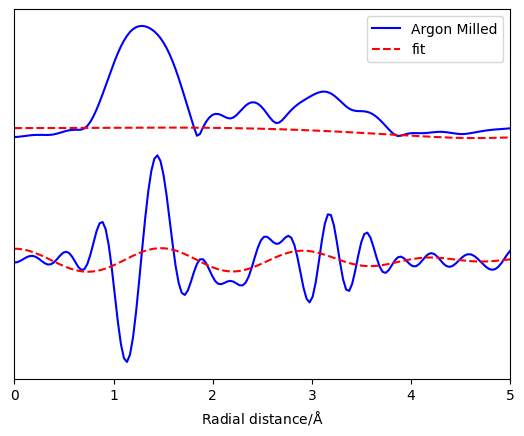

R-factor 95.32%


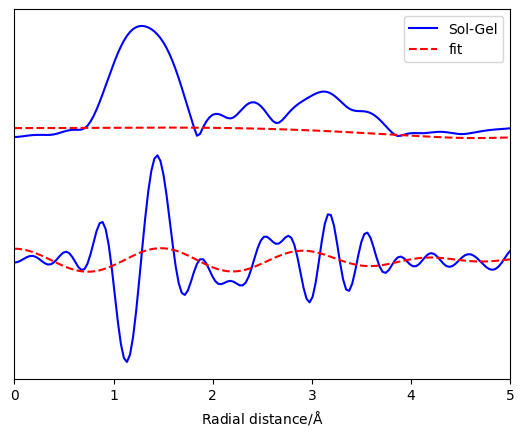

Testing paths: ['1', '1', '0', '1', '0']
R-factor 22.89%


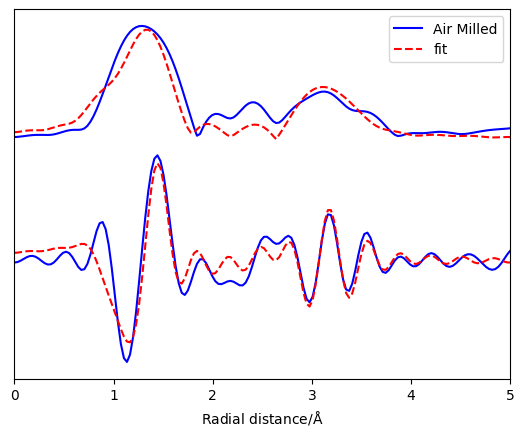

R-factor 58.85%


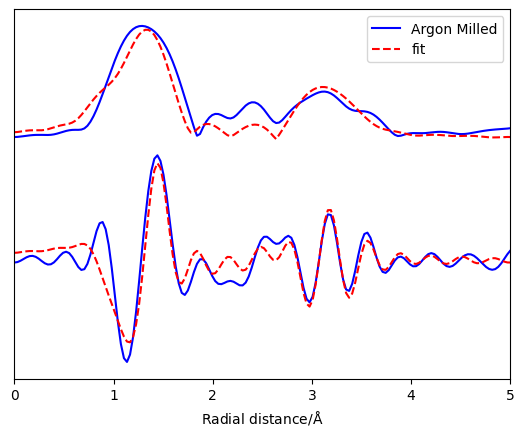

R-factor 23.76%


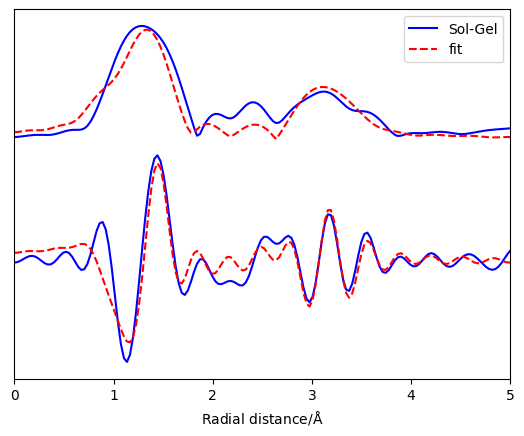

Testing paths: ['0', '0', '1', '1', '0']
R-factor 95.13%


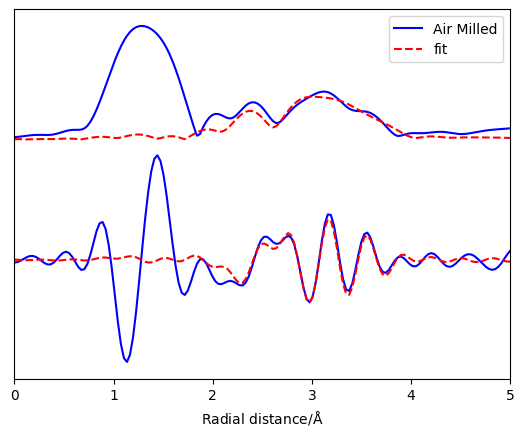

R-factor 59.42%


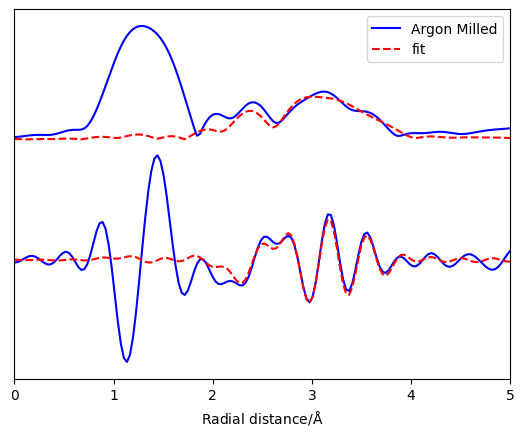

R-factor 83.38%


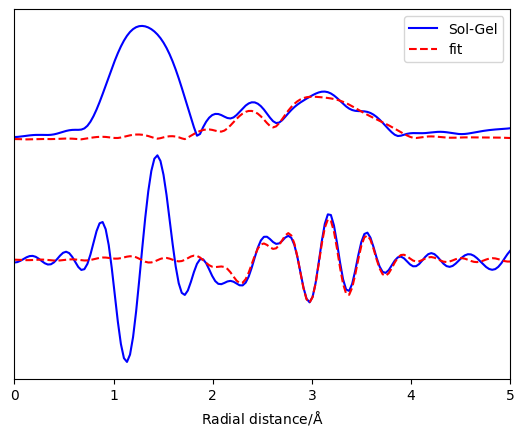

Testing paths: ['1', '0', '1', '1', '0']
R-factor 24.70%


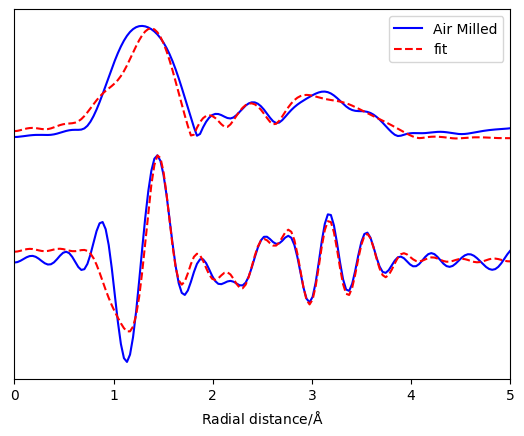

R-factor 17.23%


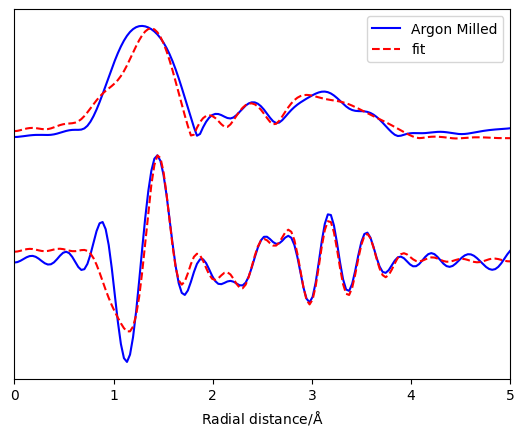

R-factor 20.63%


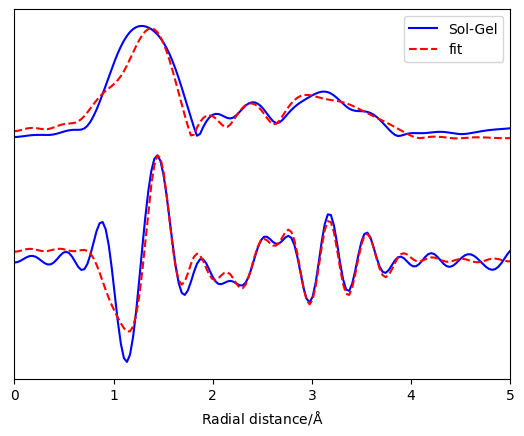

Testing paths: ['0', '1', '1', '1', '0']
R-factor 95.13%


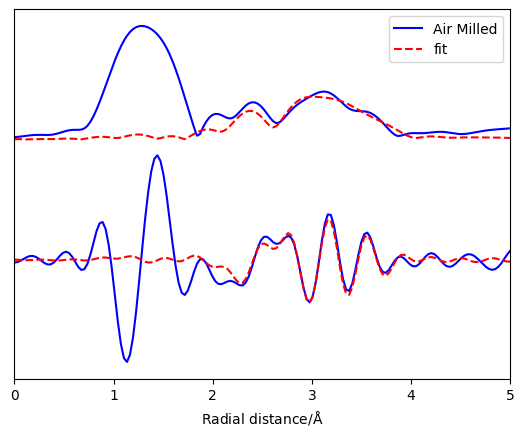

R-factor 59.42%


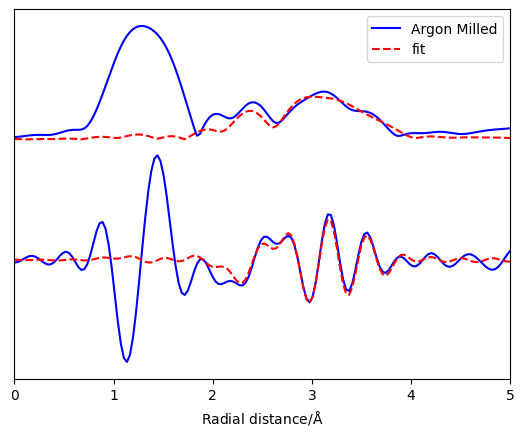

R-factor 83.38%


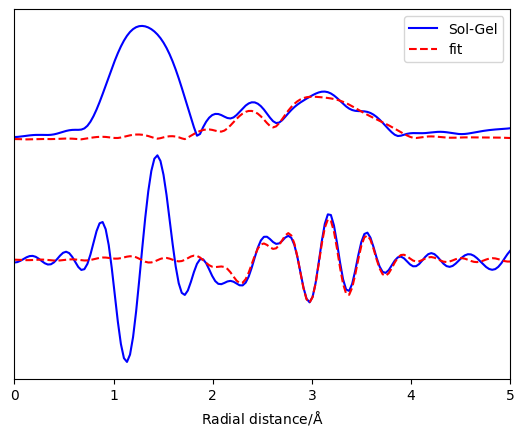

Testing paths: ['1', '1', '1', '1', '0']
R-factor 24.70%


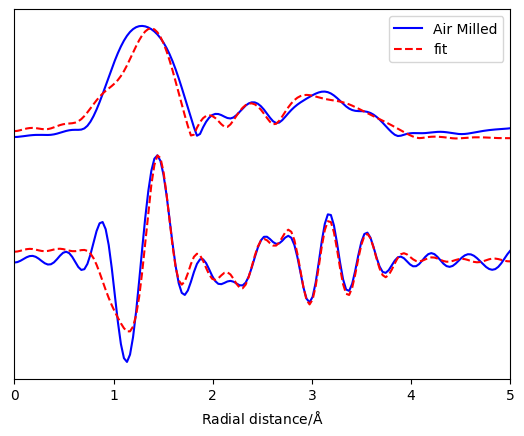

R-factor 17.23%


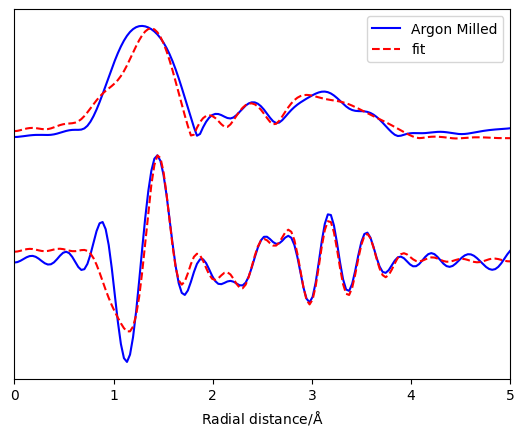

R-factor 20.63%


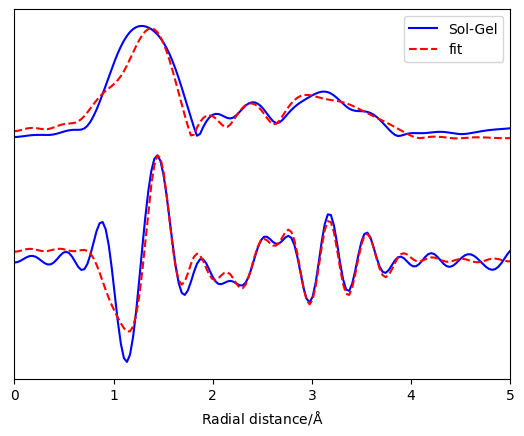

Testing paths: ['0', '0', '0', '0', '1']
R-factor 94.83%


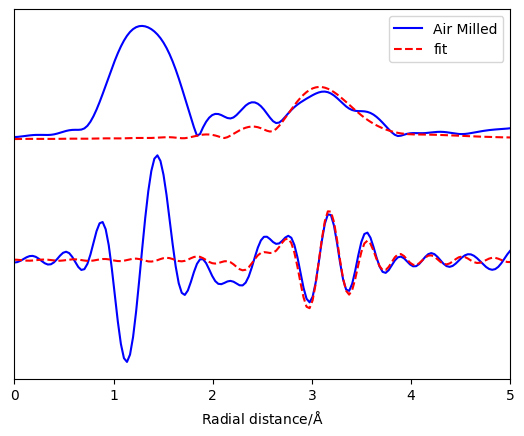

R-factor 60.45%


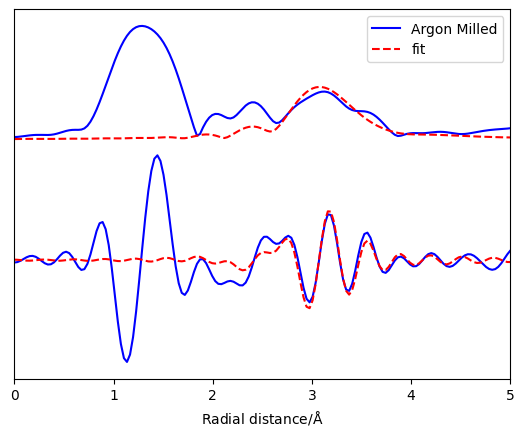

R-factor 83.34%


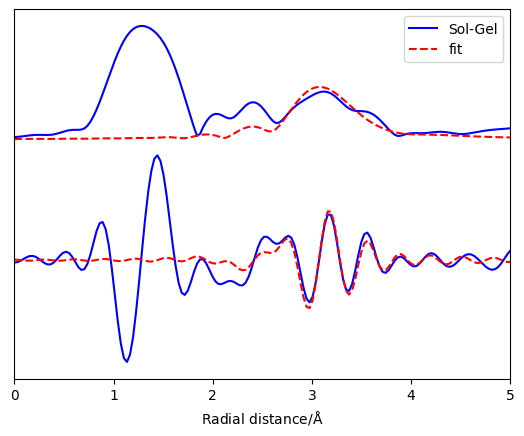

Testing paths: ['1', '0', '0', '0', '1']
R-factor 27.10%


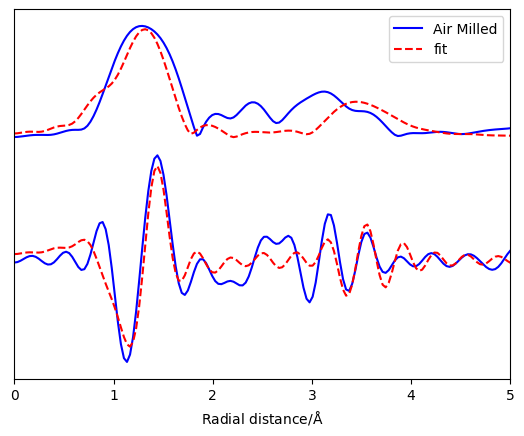

R-factor 57.96%


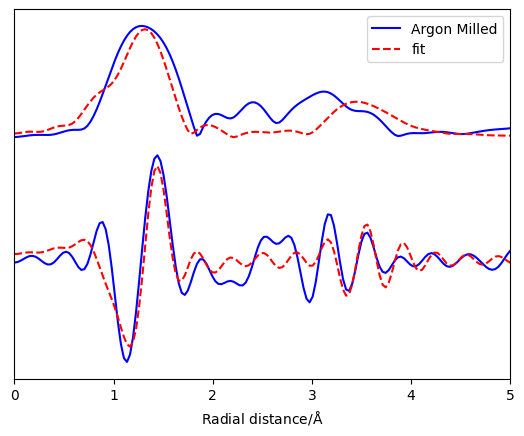

R-factor 32.02%


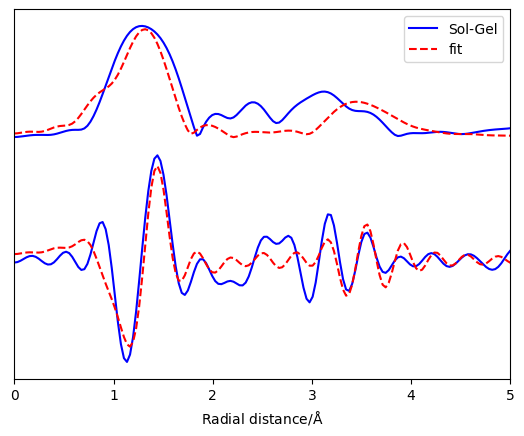

Testing paths: ['0', '1', '0', '0', '1']
R-factor 94.83%


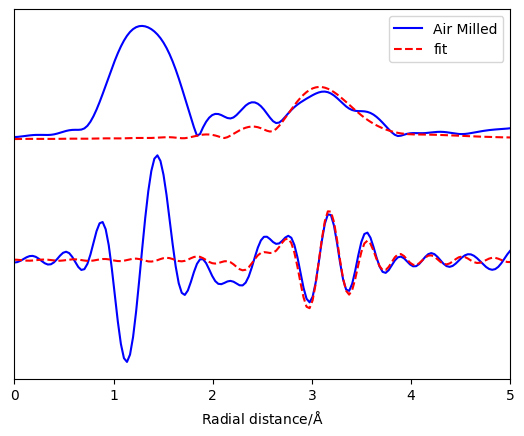

R-factor 60.45%


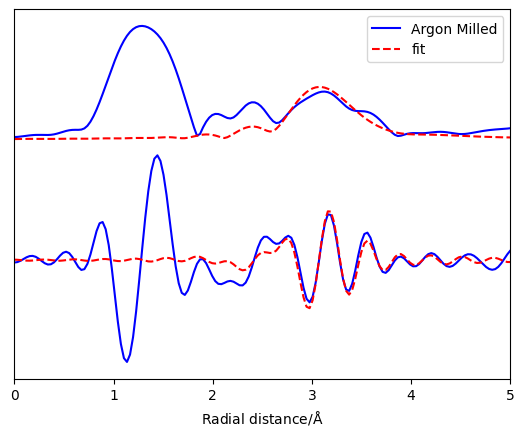

R-factor 83.34%


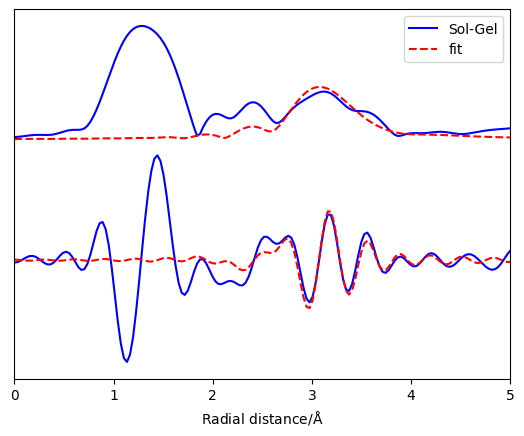

Testing paths: ['1', '1', '0', '0', '1']
R-factor 27.10%


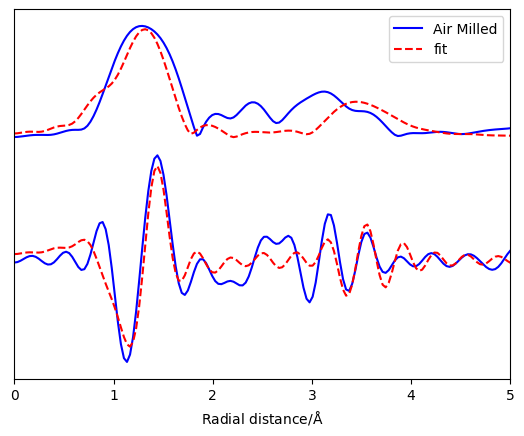

R-factor 57.96%


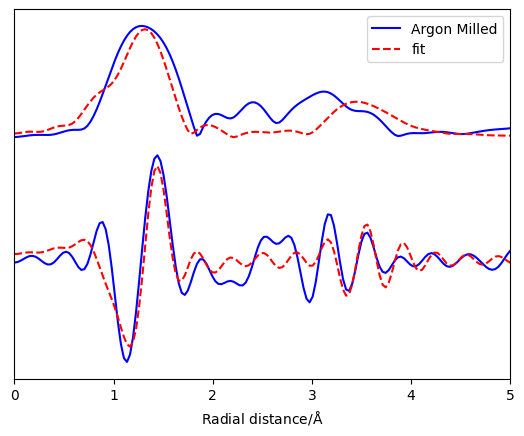

R-factor 32.02%


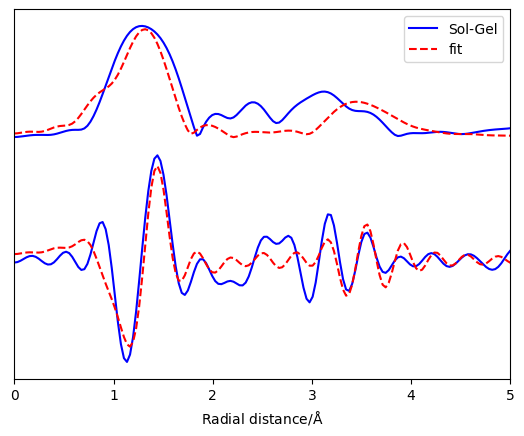

Testing paths: ['0', '0', '1', '0', '1']
R-factor 95.07%


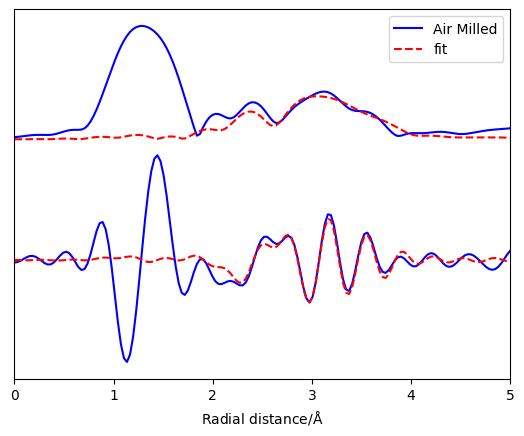

R-factor 63.19%


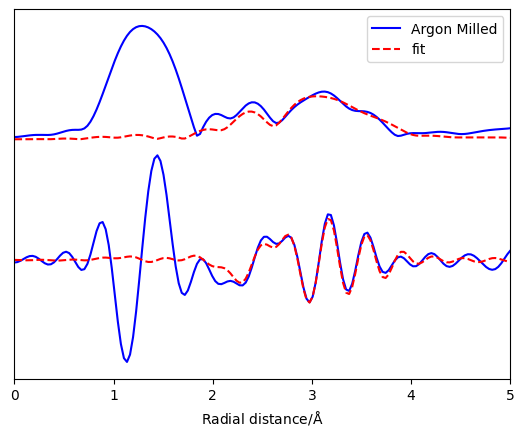

R-factor 83.21%


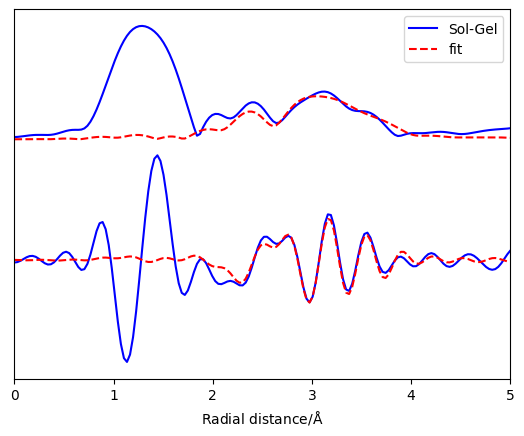

Testing paths: ['1', '0', '1', '0', '1']
R-factor 24.14%


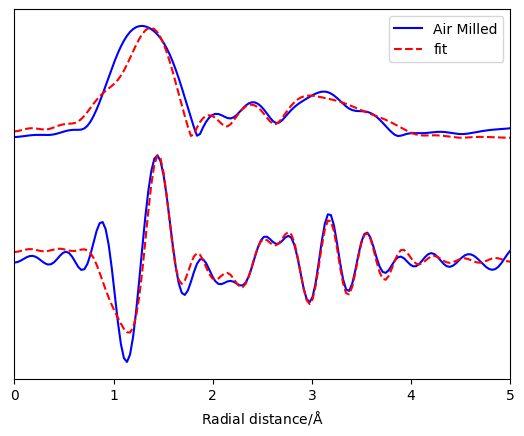

R-factor 26.00%


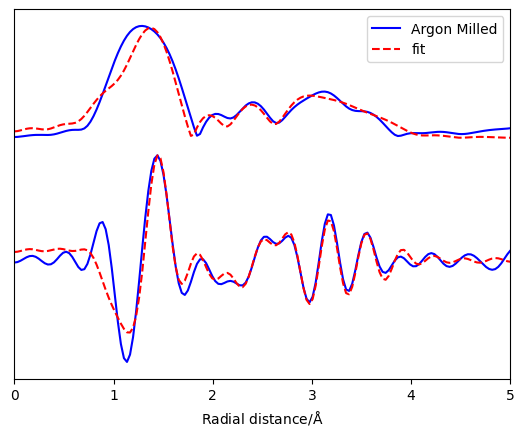

R-factor 20.36%


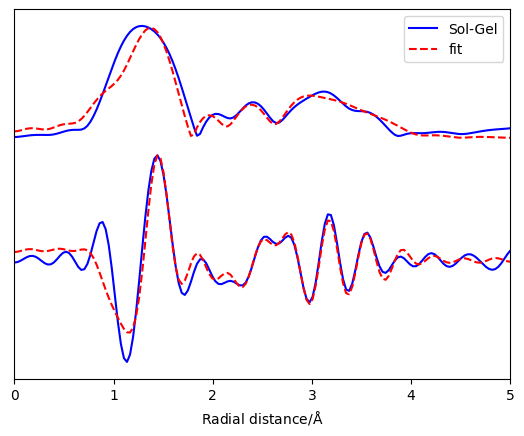

Testing paths: ['0', '1', '1', '0', '1']
R-factor 95.07%


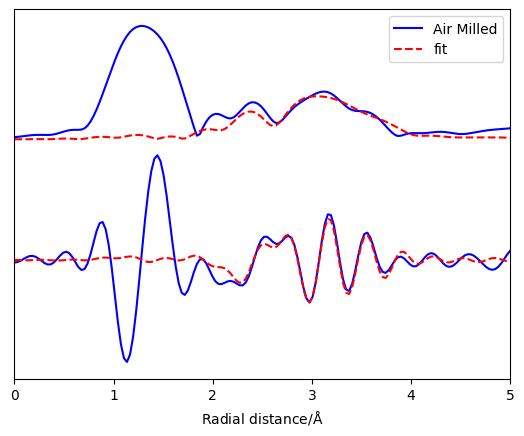

R-factor 63.19%


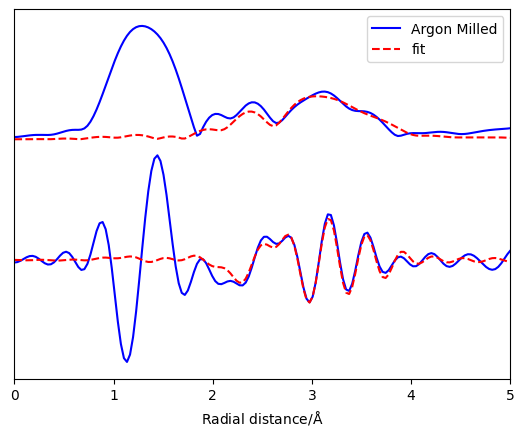

R-factor 83.21%


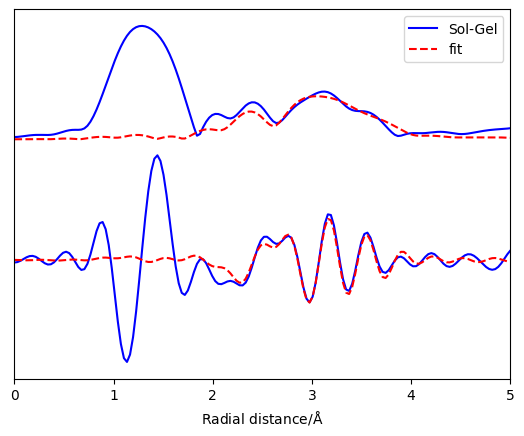

Testing paths: ['1', '1', '1', '0', '1']
R-factor 24.14%


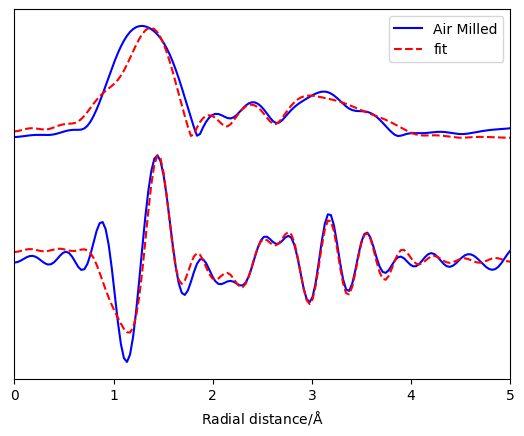

R-factor 26.00%


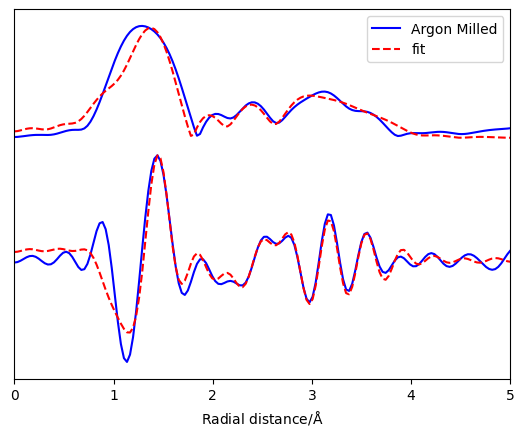

R-factor 20.36%


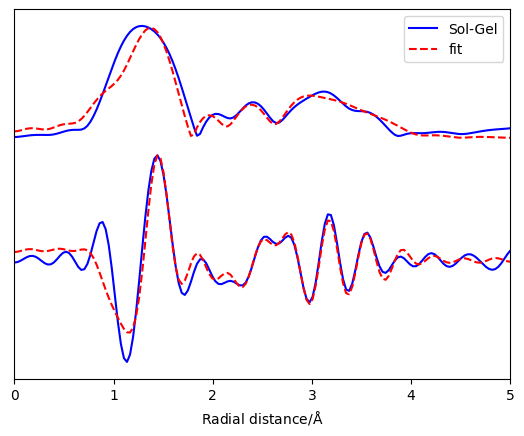

Testing paths: ['0', '0', '0', '1', '1']
R-factor 94.51%


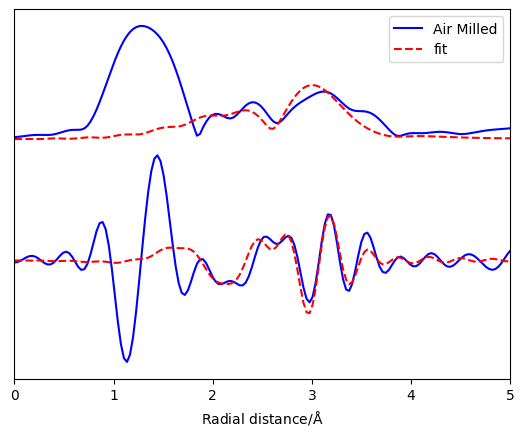

R-factor 57.46%


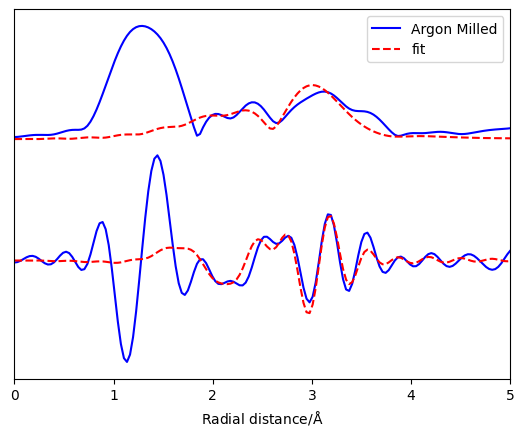

R-factor 79.68%


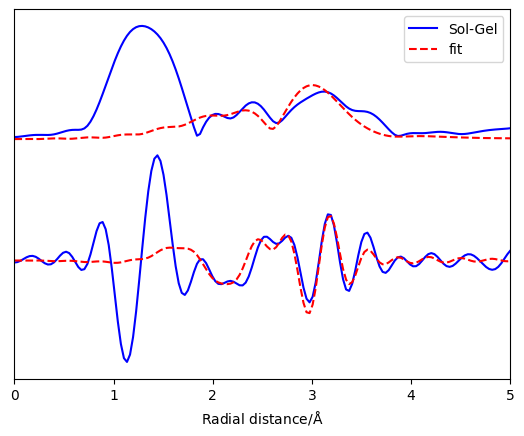

Testing paths: ['1', '0', '0', '1', '1']
R-factor 22.87%


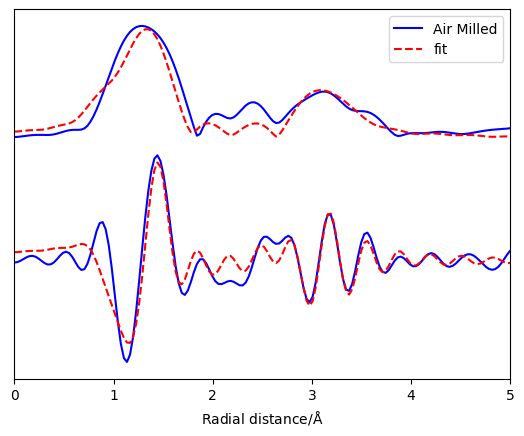

R-factor 22.89%


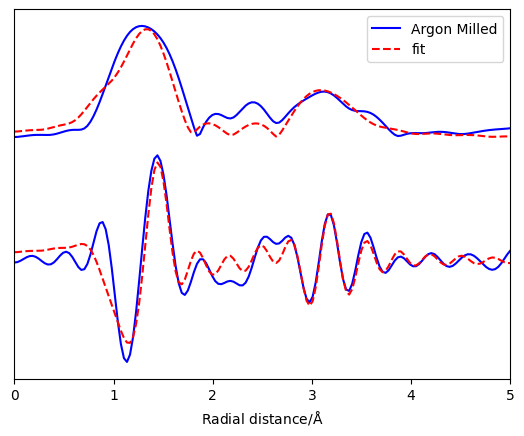

R-factor 23.58%


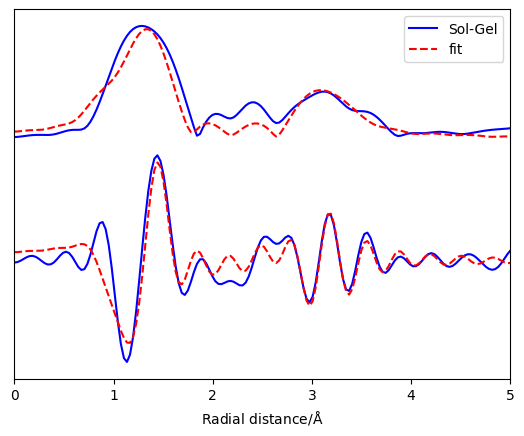

Testing paths: ['0', '1', '0', '1', '1']
R-factor 94.51%


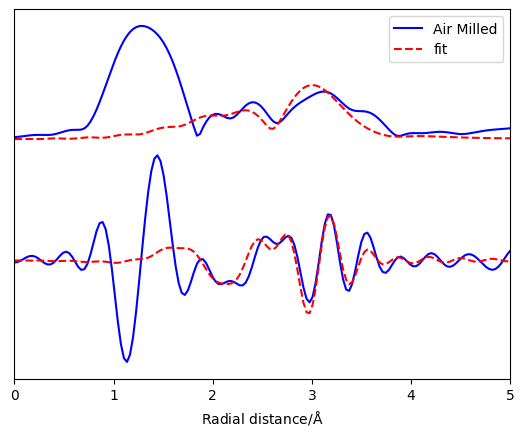

R-factor 57.46%


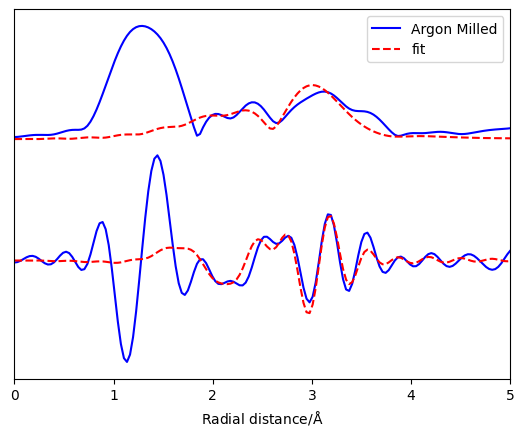

R-factor 79.68%


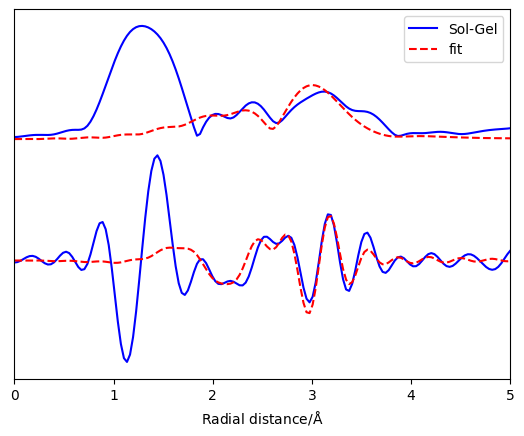

Testing paths: ['1', '1', '0', '1', '1']
R-factor 22.87%


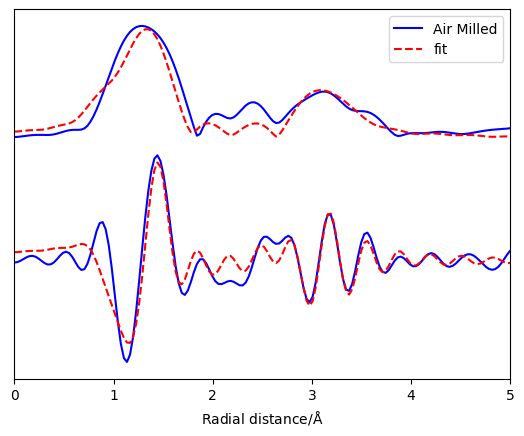

R-factor 22.89%


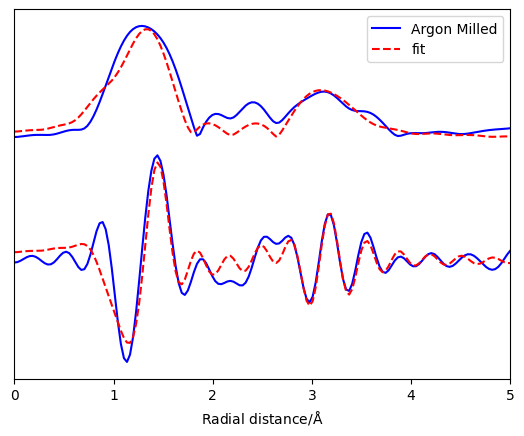

R-factor 23.58%


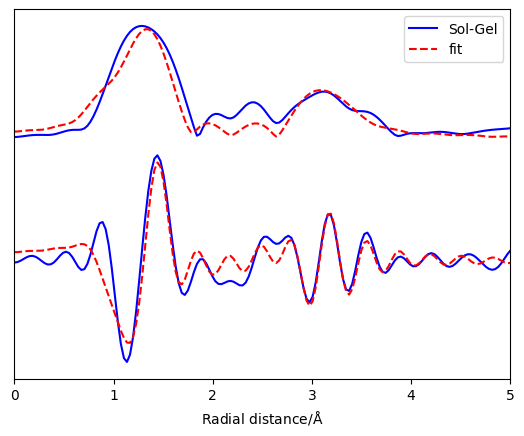

Testing paths: ['0', '0', '1', '1', '1']
R-factor 94.78%


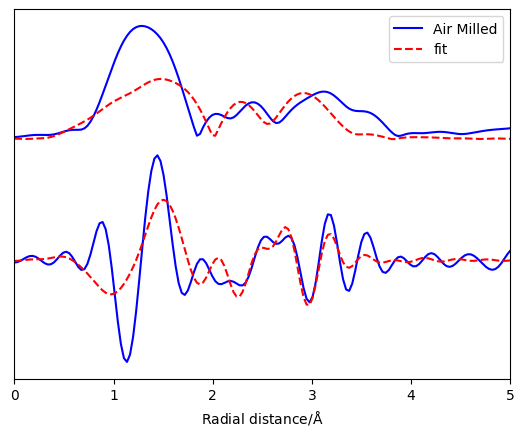

R-factor 60.14%


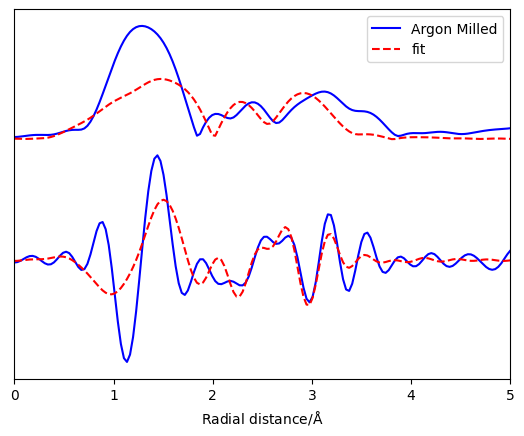

R-factor 60.01%


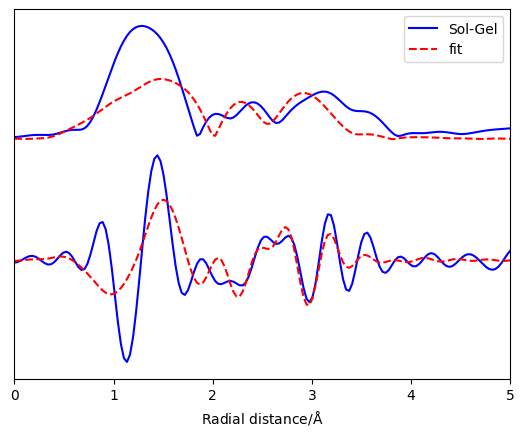

Testing paths: ['1', '0', '1', '1', '1']
Error for: Air Milled with combination ['1', '0', '1', '1', '1']
R-factor 16.37%


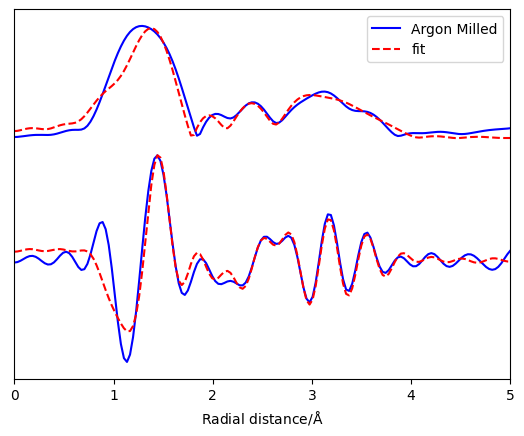

R-factor 20.46%


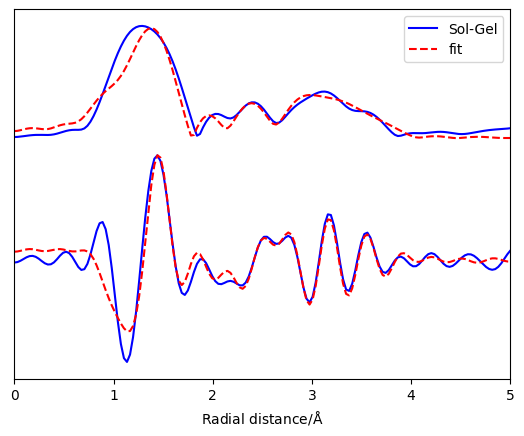

Testing paths: ['0', '1', '1', '1', '1']
R-factor 94.78%


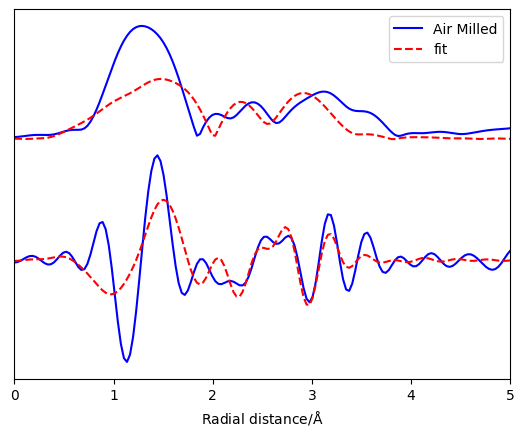

R-factor 60.14%


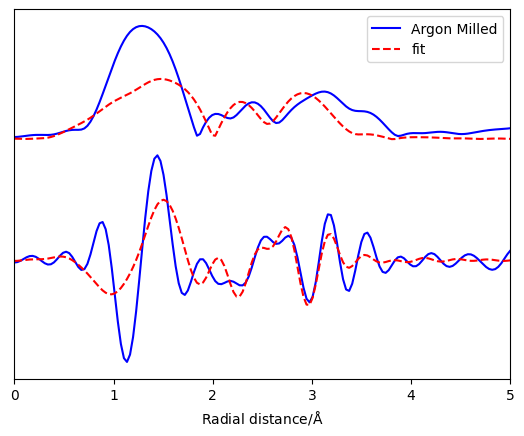

R-factor 60.01%


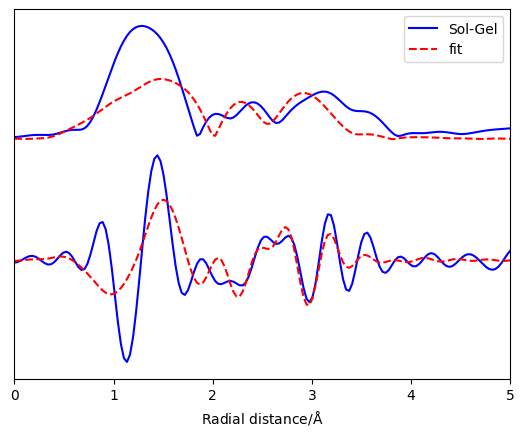

Testing paths: ['1', '1', '1', '1', '1']
Error for: Air Milled with combination ['1', '1', '1', '1', '1']
R-factor 16.37%


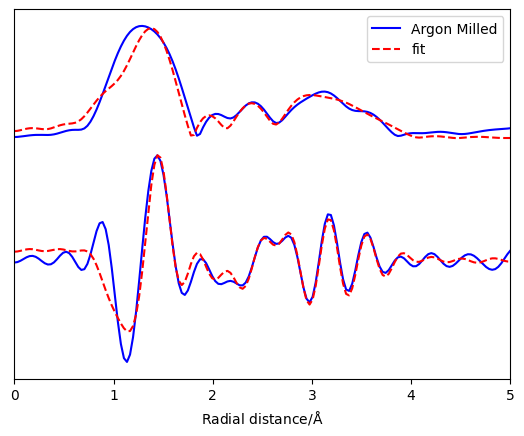

R-factor 20.46%


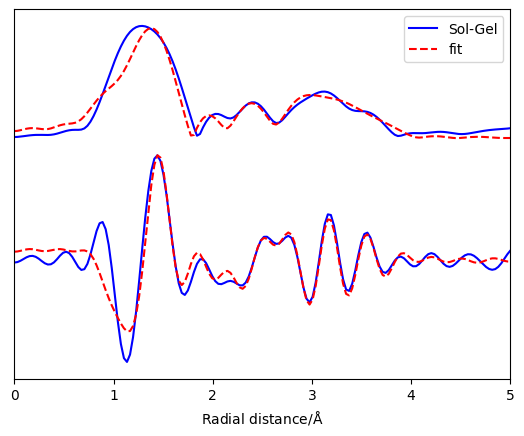

In [8]:
best_r={}
for a_test in list_combinations:
    print("Testing paths:", a_test['combination'])
    # convert the gds vars to a gds parameters group
    gds_params = fit_manager.dict_to_gds(a_test['gds_vars'], session)
    # convert the pareameter vars to a gds parameters group
    sp_list =fit_manager.dict_to_sp(a_test['sp_vars'], session)
    fit_list = {}
    for a_group in fit_groups:
        try:
            trans, dset, out = fit_manager.run_fit(f6_groups[a_group], gds_params, sp_list, fit_vars, session)
            fit_list[a_group] = [trans, dset, out]
        except:
            print("Error for:", a_group, "with combination", a_test['combination'])

    
    for a_fit in fit_list:
        print("R-factor %.2f"%(fit_list[a_fit][2].rfactor*100)+"%")
        if not a_fit in best_r:
            best_r[a_fit] = {'r_factor':fit_list[a_fit][2].rfactor, 
                             "combination": a_test['combination'],
                             'fit':fit_list[a_fit]}
        elif best_r[a_fit]['r_factor'] > fit_list[a_fit][2].rfactor:
            best_r[a_fit] = {'r_factor':fit_list[a_fit][2].rfactor, 
                             "combination": a_test['combination'],
                             "pattern":a_test['c_pattern'],
                             'fit':fit_list[a_fit]}
        chikr_p = custom_plots.plot_rmr(dset,fit_vars['rmin'],fit_vars['rmax'], a_fit)
        chikr_p.show()
    

The smallest R factor identifies the best fits for the data. These are saved in best_r

# 5. Show best combination results
The smallest R factor identifies the best fits for the data. These are saved in best_r

Selected paths for Air Milled: ['O.Mn1', 'Mn.Mn4', 'Mn.Mn5'] (10011) R-Factor: 22.87%


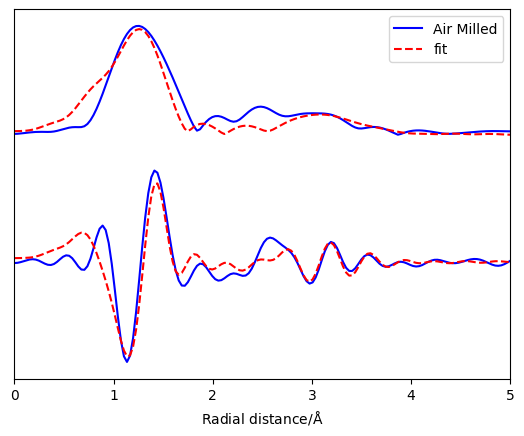

Selected paths for Argon Milled: ['O.Mn1', 'La.Mn3', 'Mn.Mn4', 'Mn.Mn5'] (10111) R-Factor: 16.37%


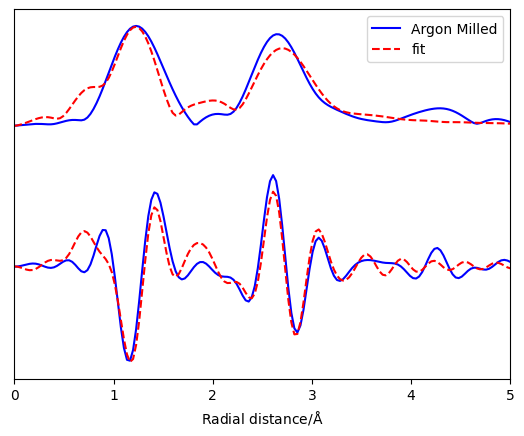

Selected paths for Sol-Gel: ['O.Mn1', 'La.Mn3', 'Mn.Mn5'] (10101) R-Factor: 20.36%


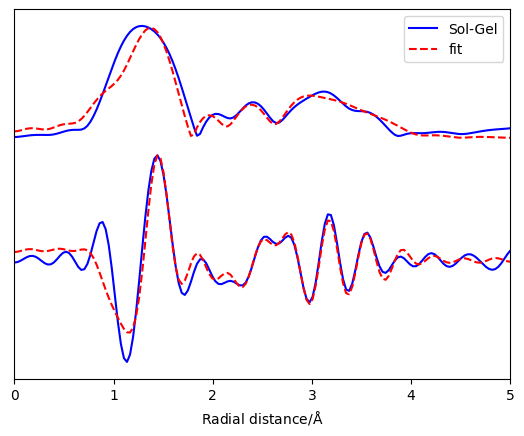

In [9]:
paths = []
for a_result in best_r:
    paths = []
    for idx in range(0,5):
        if best_r[a_result]['combination'][idx]=='1':
            paths.append(paths_info[str(idx+1)]['label'] + paths_info[str(idx+1)]['index'])
    print("Selected paths for " + a_result+ ":", paths, 
          "(" + best_r[a_result]['pattern'] +") R-Factor:", 
          "%.2f"%(best_r[a_result]['r_factor']*100)+"%")
    
    best_r[a_result]['paths_list']=paths

    chikr_p = custom_plots.plot_rmr(best_r[a_result]['fit'][1], 
                                    fit_vars['rmin'],fit_vars['rmax'], 
                                    a_result)
    chikr_p.show()


# 6. Save results 

Save the metadata for reproducing the best path combinations


In [10]:
# get parameters for saving results
save_variables = operations_data['task_list'][5]['variables']

out_location = save_variables['out_location']
out_prefix = save_variables['out_prefix']

# create a new output dir if it does not exist
out_dir = athenamgr.set_out_dir(out_prefix,out_location)

out_file_name = Path(out_dir, out_prefix+'_lcf.json')

for a_result in best_r:
    fit_report = fit_manager.get_fit_report(best_r[a_result]['fit'][2], session)
    # show the fit report
    print("v"*30, a_result, "v"*30)
    print(fit_report)
    #save the fit report to a text file
    out_file_name = Path(out_dir, a_result.replace(" ","_") + "_fit_rep.txt")
    gds_file_name = Path(out_dir, a_result.replace(" ","_") + "_gds.csv")
    sp_file_name = Path(out_dir, a_result.replace(" ","_") + "_sp.csv")
    print("Fit report:", out_file_name)
    fit_manager.save_fit_report(best_r[a_result]['fit'][2], out_file_name, session)
    for a_combination in list_combinations:
        if a_combination['c_pattern'] == best_r[a_result]['pattern']:
            #print(a_combination['gds_vars'])
            gds_params = fit_manager.dict_to_gds(a_combination['gds_vars'], session)
            print("GDS file:", gds_file_name)
            fit_manager.save_gds(gds_params, gds_file_name)
            # take sp list and convert it to a dictionary
            sp_dict = {}
            for a_path in a_combination['sp_vars']:
                sp_dict[a_path['id']] = a_path
            print("Selected paths file:", sp_file_name)
            csvhandler.write_csv_data(sp_dict,sp_file_name)

vvvvvvvvvvvvvvvvvvvvvvvvvvvvvv Air Milled vvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  8, 200
   n_independent      =  32.831
   chi_square         =  7197509.38
   reduced chi_square =  289859.960
   r-factor           =  0.22865700
   Akaike info crit   =  419.751321
   Bayesian info crit =  431.682303
 
[[Data]]
   fit space          = 'k'
   r-range            = 0.000, 5.000
   k-range            = 0.000, 10.000
   k window, dk       = 'hanning', 1.000
   paths used in fit  = ['./1667441_feff/feff0001.dat', './1667441_feff/feff0004.dat', './1667441_feff/feff0005.dat']
   k-weight           = 2
   epsilon_k          = Array(mean=0.00102258, std=0.00170135)
   epsilon_r          = 0.00912201
   n_independent      = 32.831
 
[[Variables]]
   amp            =  0.68169541 +/- 0.16260666   (init=  1.00000000)
   delr_1         = -0.07724864 +/- 0.02003207   (init=  0.00000000)
   delr_4         = -0.2524829

# References 

This notebook uses supporting data from this article

R. H. Blackmore, M. E. Rivas, G. F. Tierney, K. M. H. .Mohammed, D. Decarolis, S. Hayama, F. Venturini, G. Held, R. Arrigo, M. Amboage, P. Hellier, E. W. Lynch, M. Amri, M. Casavola, T. Eralp Erden, P. Collier, P. P. Wells (2020) **The electronic structure, surface properties, and in situ N<sub>2</sub>O decomposition of mechanochemically synthesised LaMnO<sub>3</sub>** DOI: [10.1039/d0cp00793e](http://doi.org/10.1039/d0cp00793e).

The data used for has been published in the University of Southampton Institutional Repository doi:[10.5258/SOTON/D1342](http://dx.doi.org/10.5258/SOTON/D1342)


For more details about Larch, see [Larch Website](https://xraypy.github.io/xraylarch/xafs/)